In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
#import scanorama
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

### Глобальные переменные

In [2]:
qc_palette = sns.color_palette(['red', 'gray'])

In [3]:
layer_palette = {'Empty spots': '#1f77b4',
                 'WM': '#bcbd22',
                 'L1': '#ff7f0e',
                 'L6': '#e377c2',
                 'L2': '#2ca02c',
                 'L3': '#d62728',
                 'L4': '#9467bd',
                 'L5': '#8c564b',
                 'L6a': '#ffc0cb',
                 'L6b': '#fa9284'}

# Подгрузим файлы

In [4]:
# Define paths and get sample_ids
file_list = os.listdir('../data/raw_spatial_data/macaque/')
file_list

['macaque_0701', 'macaque_0703', 'macaque_0704', 'macaque_nb0904']

In [5]:
file = 'macaque_0704'

In [6]:
# аннотация слоёв
ann = pd.read_csv('../data/clusters/' + file + '.csv', index_col=0)
ann.columns = ['label']
ann.head()

label
Barcode                 
AAACAAGTATCTCCCA-1    L1
AAACACCAATAACTGC-1    L5
AAACAGAGCGACTCCT-1    L3
AAACAGCTTTCAGAAG-1    L3
AAACAGGGTCTATATT-1    L3

In [7]:
# каунты секвенирования
adata = sc.read_visium('../data/raw_spatial_data/macaque/'+ file)
adata.var_names_make_unique()
adata.obs['label'] = ann.label
adata.obs['sample_id'] = file

reading ..\data\raw_spatial_data\macaque\macaque_0704\filtered_feature_bc_matrix.h5
 (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# adata

## Посчитаем метрики

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['hb'] = adata.var_names.str.contains(("^HB[AB]"))
adata.var['ribo'] = adata.var_names.str.contains(("^RP[LS]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt','hb','ribo'],
    percent_top=None, log1p=False, inplace=True)

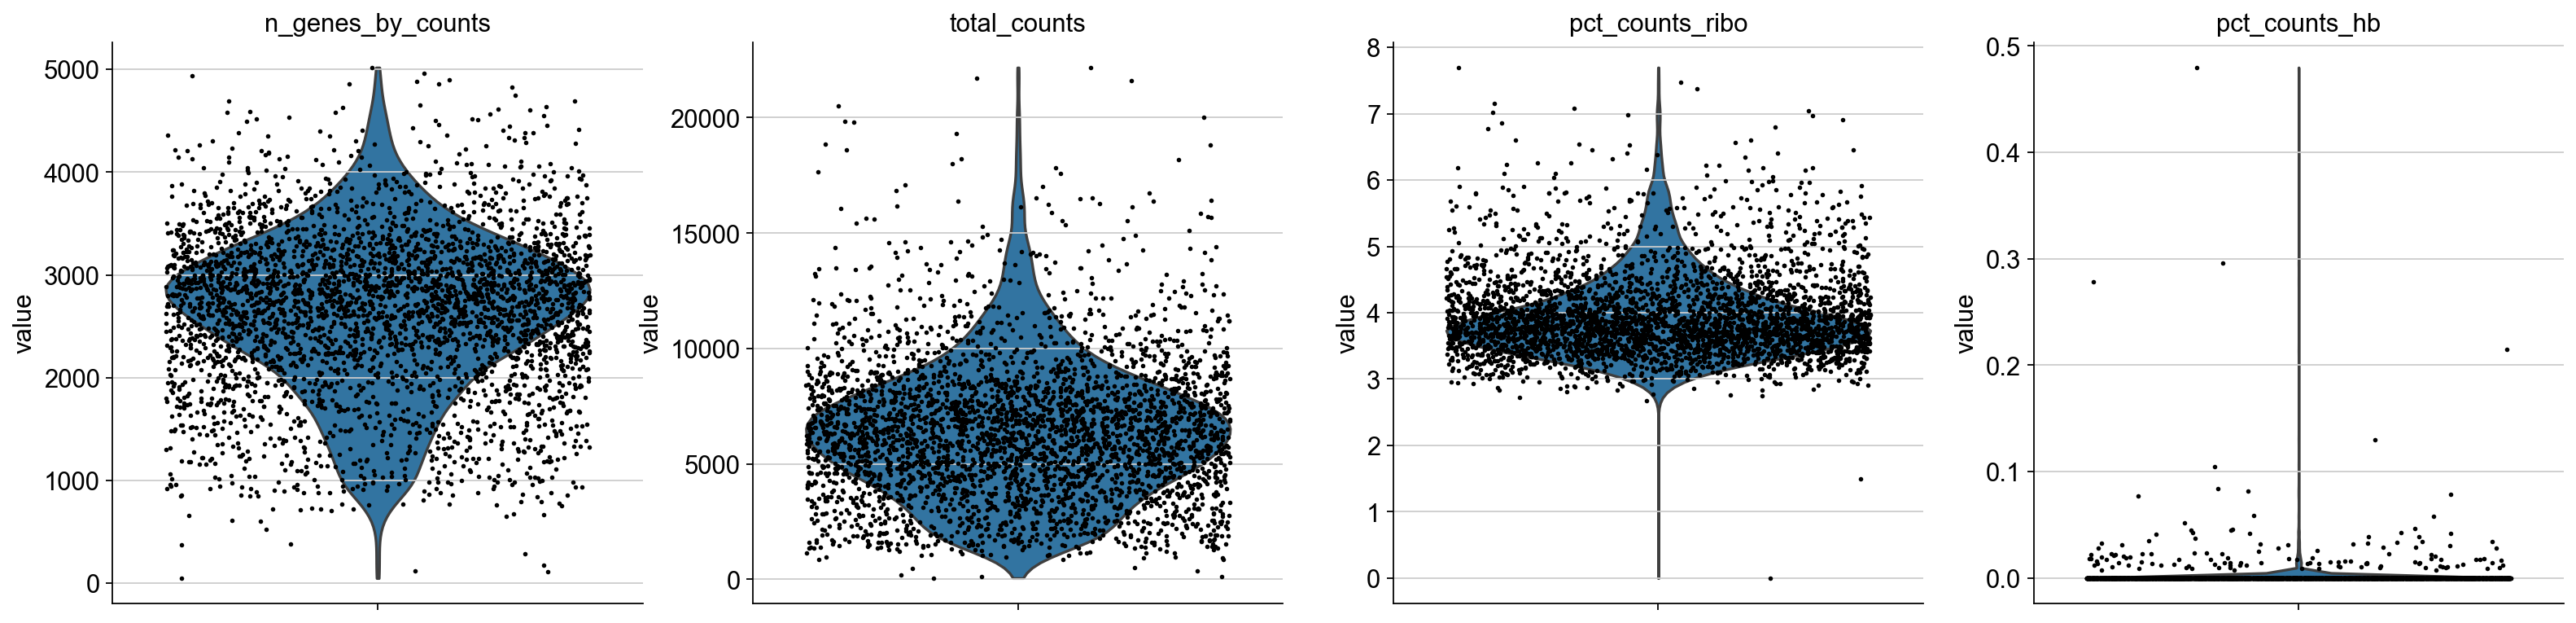

In [9]:
sc.pl.violin(adata,
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, rotation= 45, multi_panel=True, size=2.5)

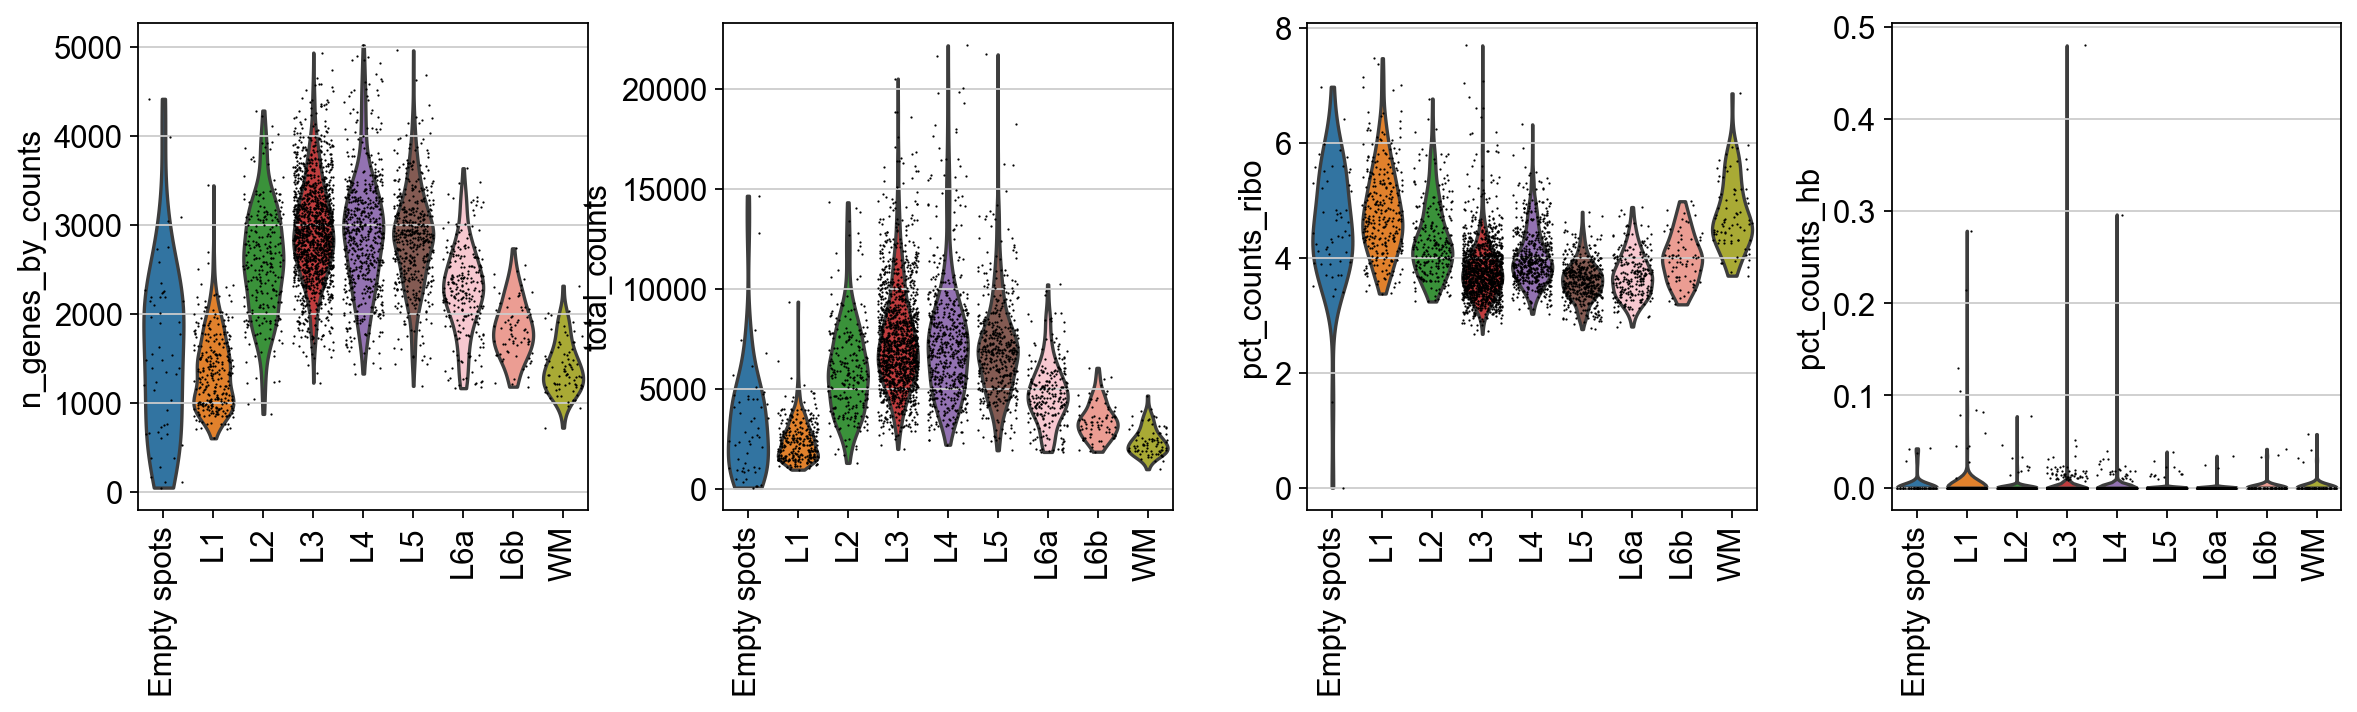

In [10]:
sc.pl.violin(adata,
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'label', rotation= 90, palette=layer_palette)

Видим, что число каунтов и задетектированых генов занижено у `L1`, `L6` и `WM` слоёв. Поэтому хотелось бы быть с ними аккуратнее. Информации по митохондриальным генам нету, будем ориентироваться на рибосомные

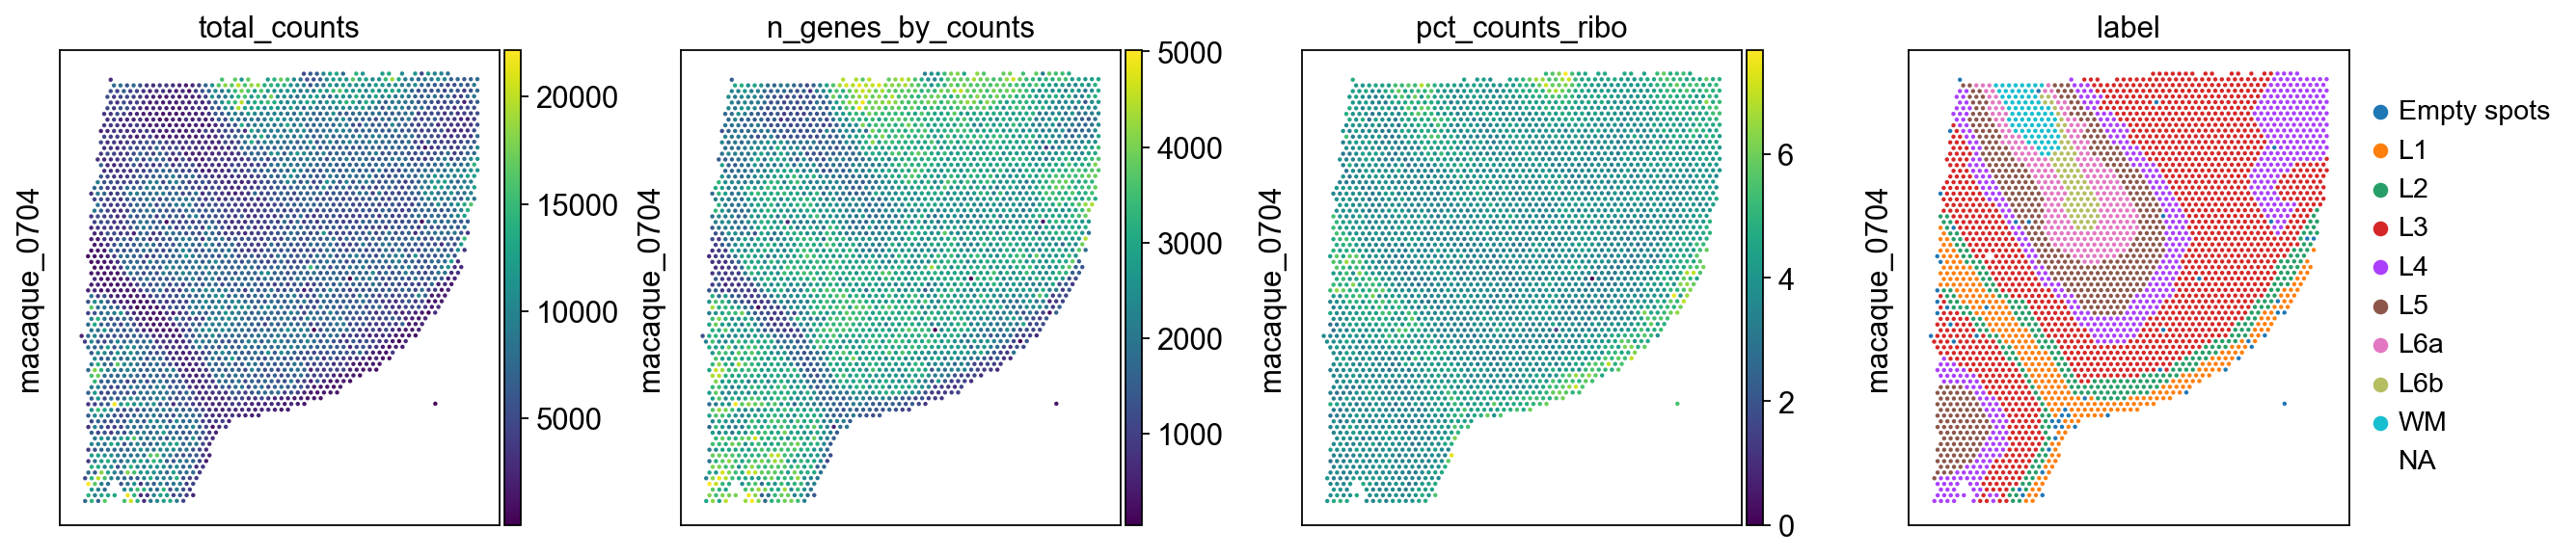

In [11]:
sq.pl.spatial_scatter(adata,
                      color = ['total_counts', 'n_genes_by_counts','pct_counts_ribo', 'label'],
                      ncols=4, img=False, axis_label=['', file])

### Libriary size

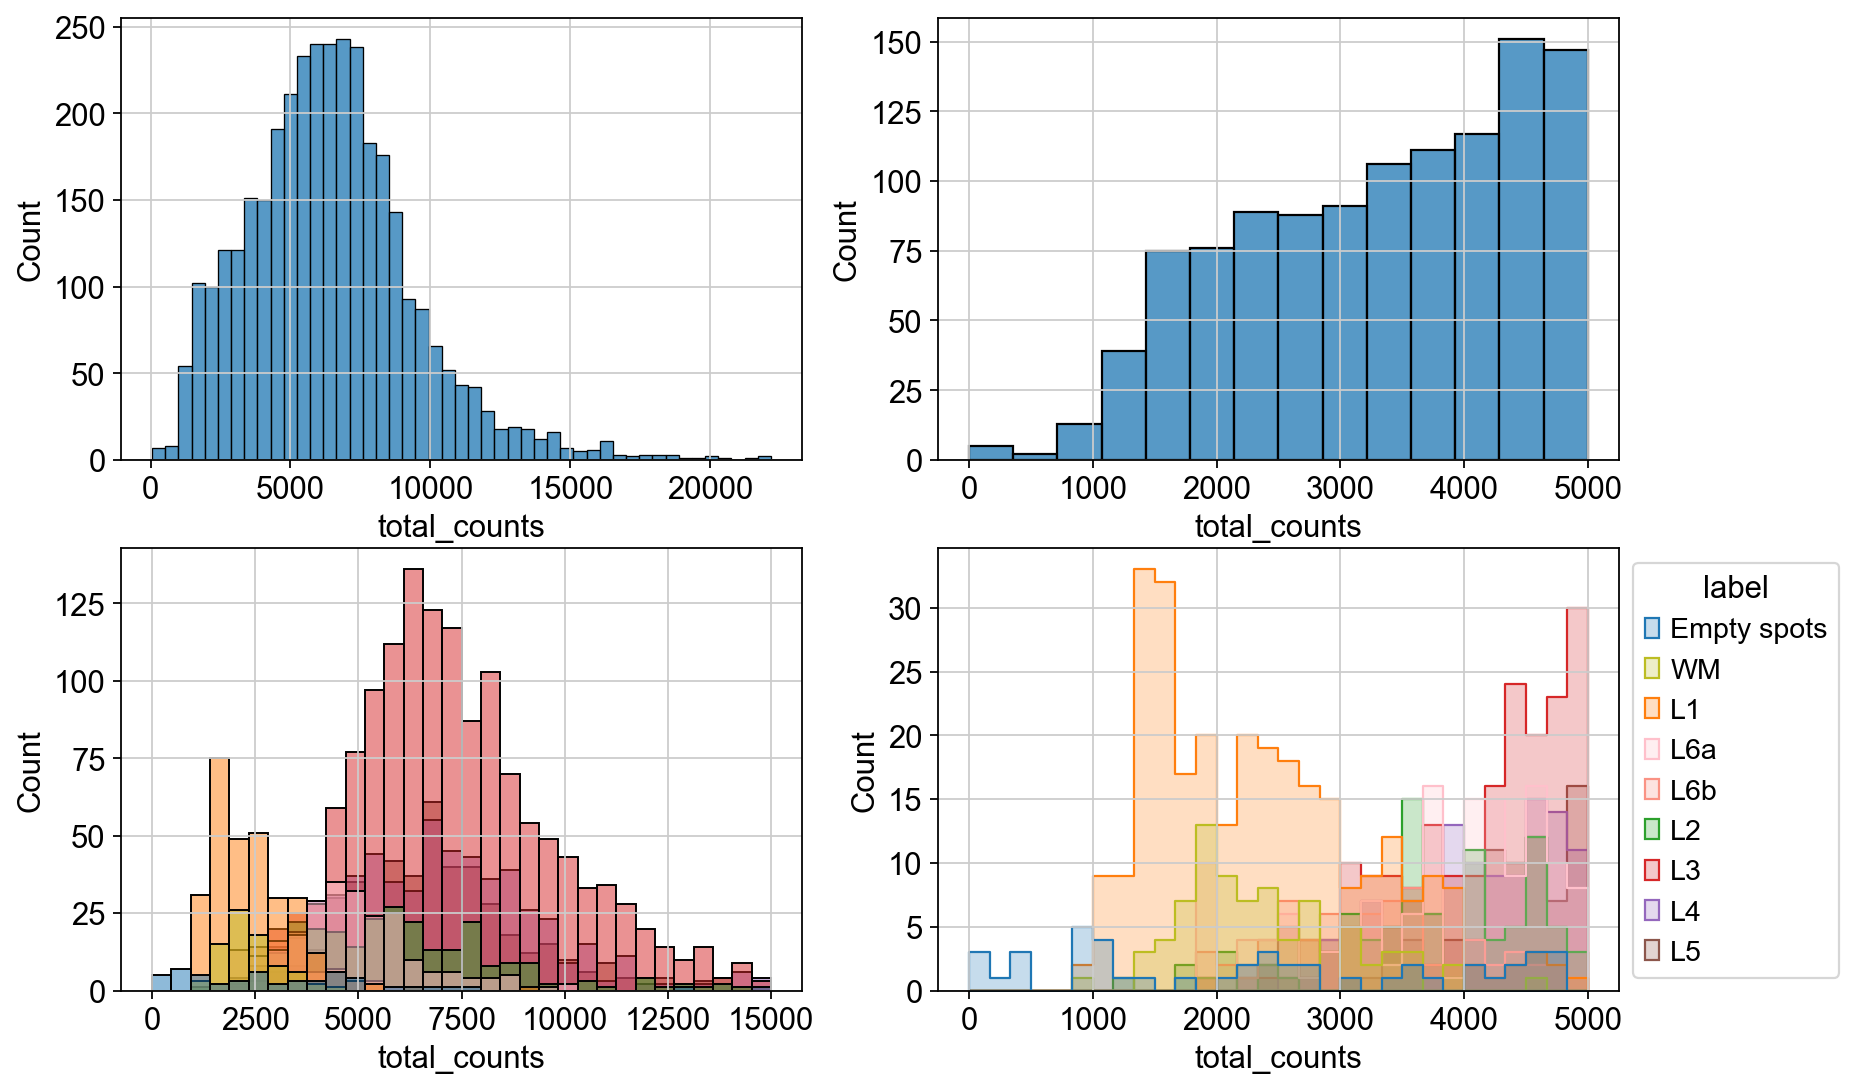

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='total_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 15000], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False, palette=layer_palette)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='total_counts', binrange=[0, 5000], ax=axs[0][1])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 5000], bins=30, hue='label',fill=True, element="step", hue_order=hue_order, ax=axs[1][1], palette=layer_palette)
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Выберем порог по `total counts = 2000`. Поставим порог для `L6` и для всех остальных по отдельности

In [15]:
adata.obs['qc_lib_size'] = ((adata.obs['total_counts'] > 1200)).astype('string')
#adata.obs['qc_lib_size'].replace({True: 'TRUE', False: 'FALSE'}, inplace=True)

vc = adata.obs.groupby('qc_lib_size')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_lib_size'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=29

label
Empty spots    16
L1             12
WM              1
Name: label, dtype: int64


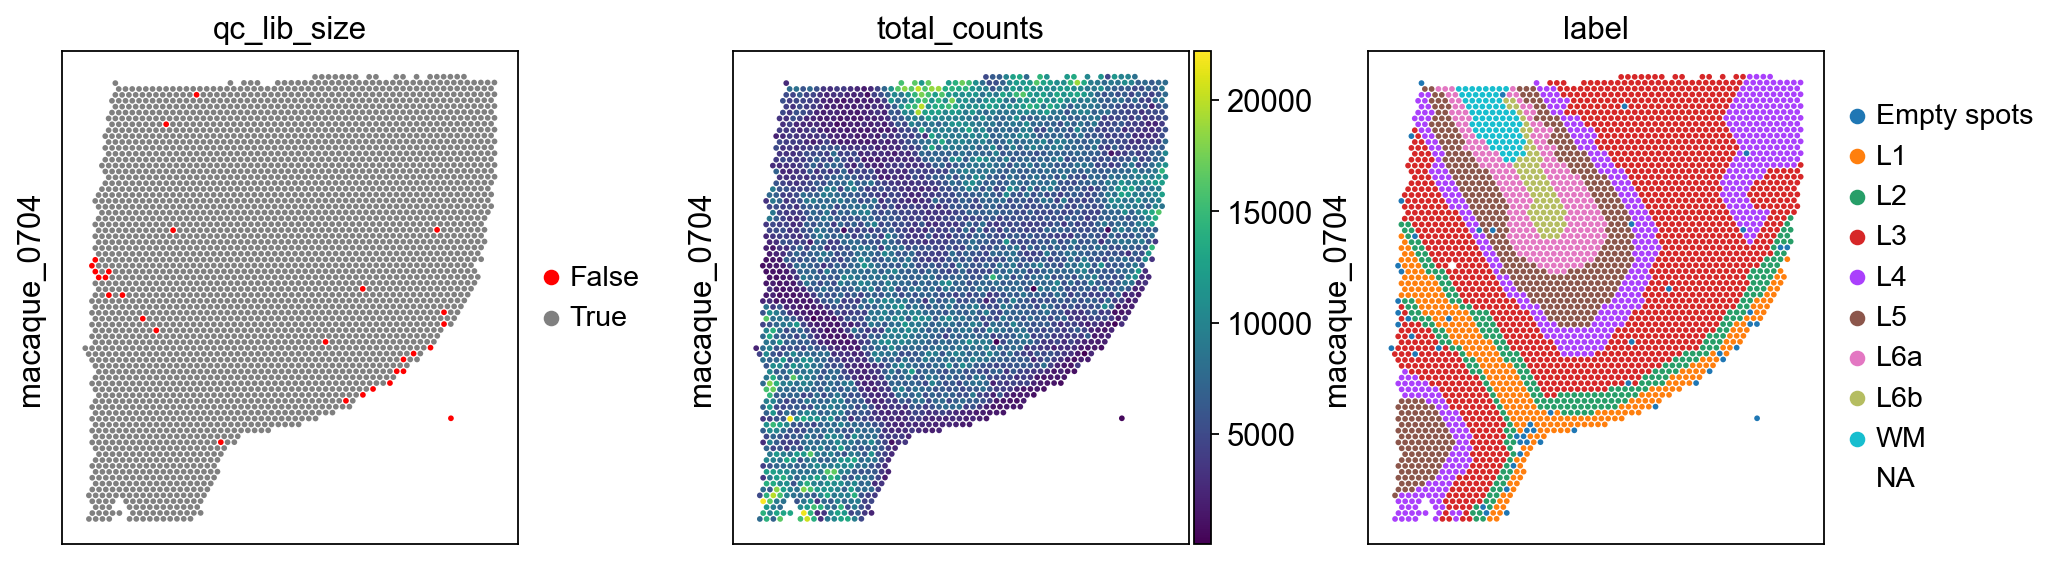

In [16]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_lib_size', 'total_counts', 'label'], img=False, axis_label=['', file], size=1.3)

### Number of expressed features

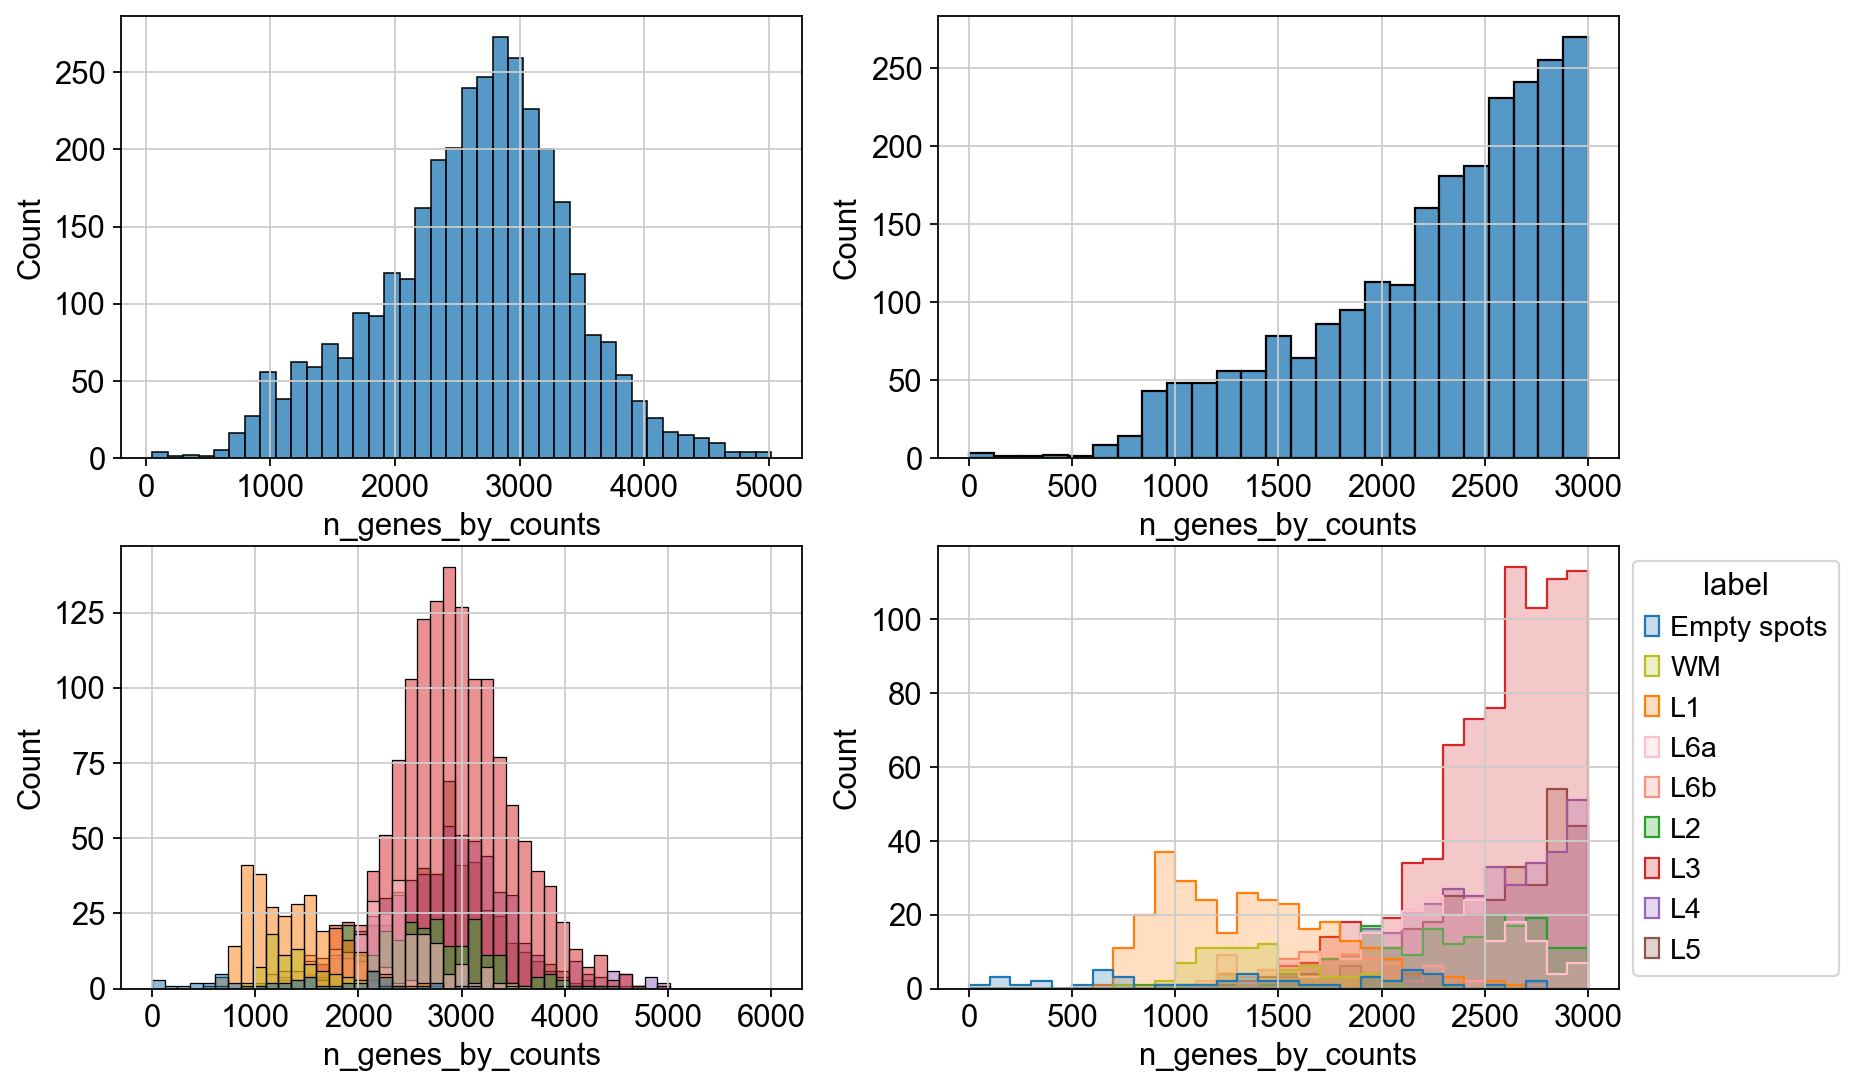

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='n_genes_by_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 6000], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False, palette=layer_palette)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 3000], ax=axs[0][1])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 3000], bins=30, hue='label',fill=True, element="step", hue_order=hue_order, ax=axs[1][1], palette=layer_palette)
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Выберем порог по `total n_genes_by_counts = 1000`. Поставим порог для `WM` и для всех остальных по отдельности

In [20]:
adata.obs['qc_n_genes'] = ((adata.obs['n_genes_by_counts'] > 800)).astype('string')
#adata.obs['qc_n_genes'].replace({True: 'True', False: 'False'}, inplace=True)
vc = adata.obs.groupby('qc_n_genes')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_n_genes'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=29

label
Empty spots    16
L1             12
WM              1
Name: label, dtype: int64


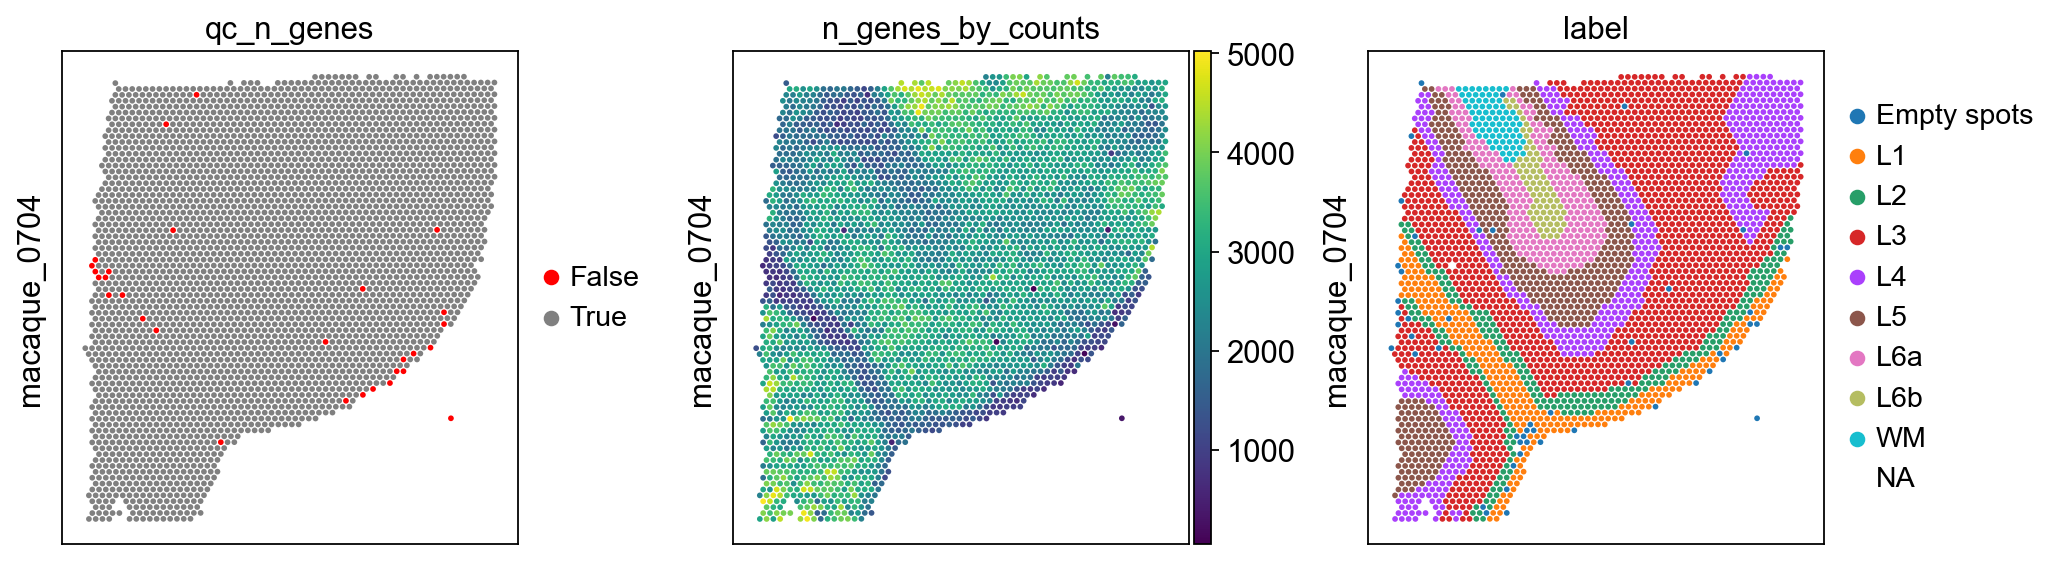

In [21]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_n_genes', 'n_genes_by_counts', 'label'], img=False, axis_label=['', file], size=1.3)

### Proportion of ribosomal reads

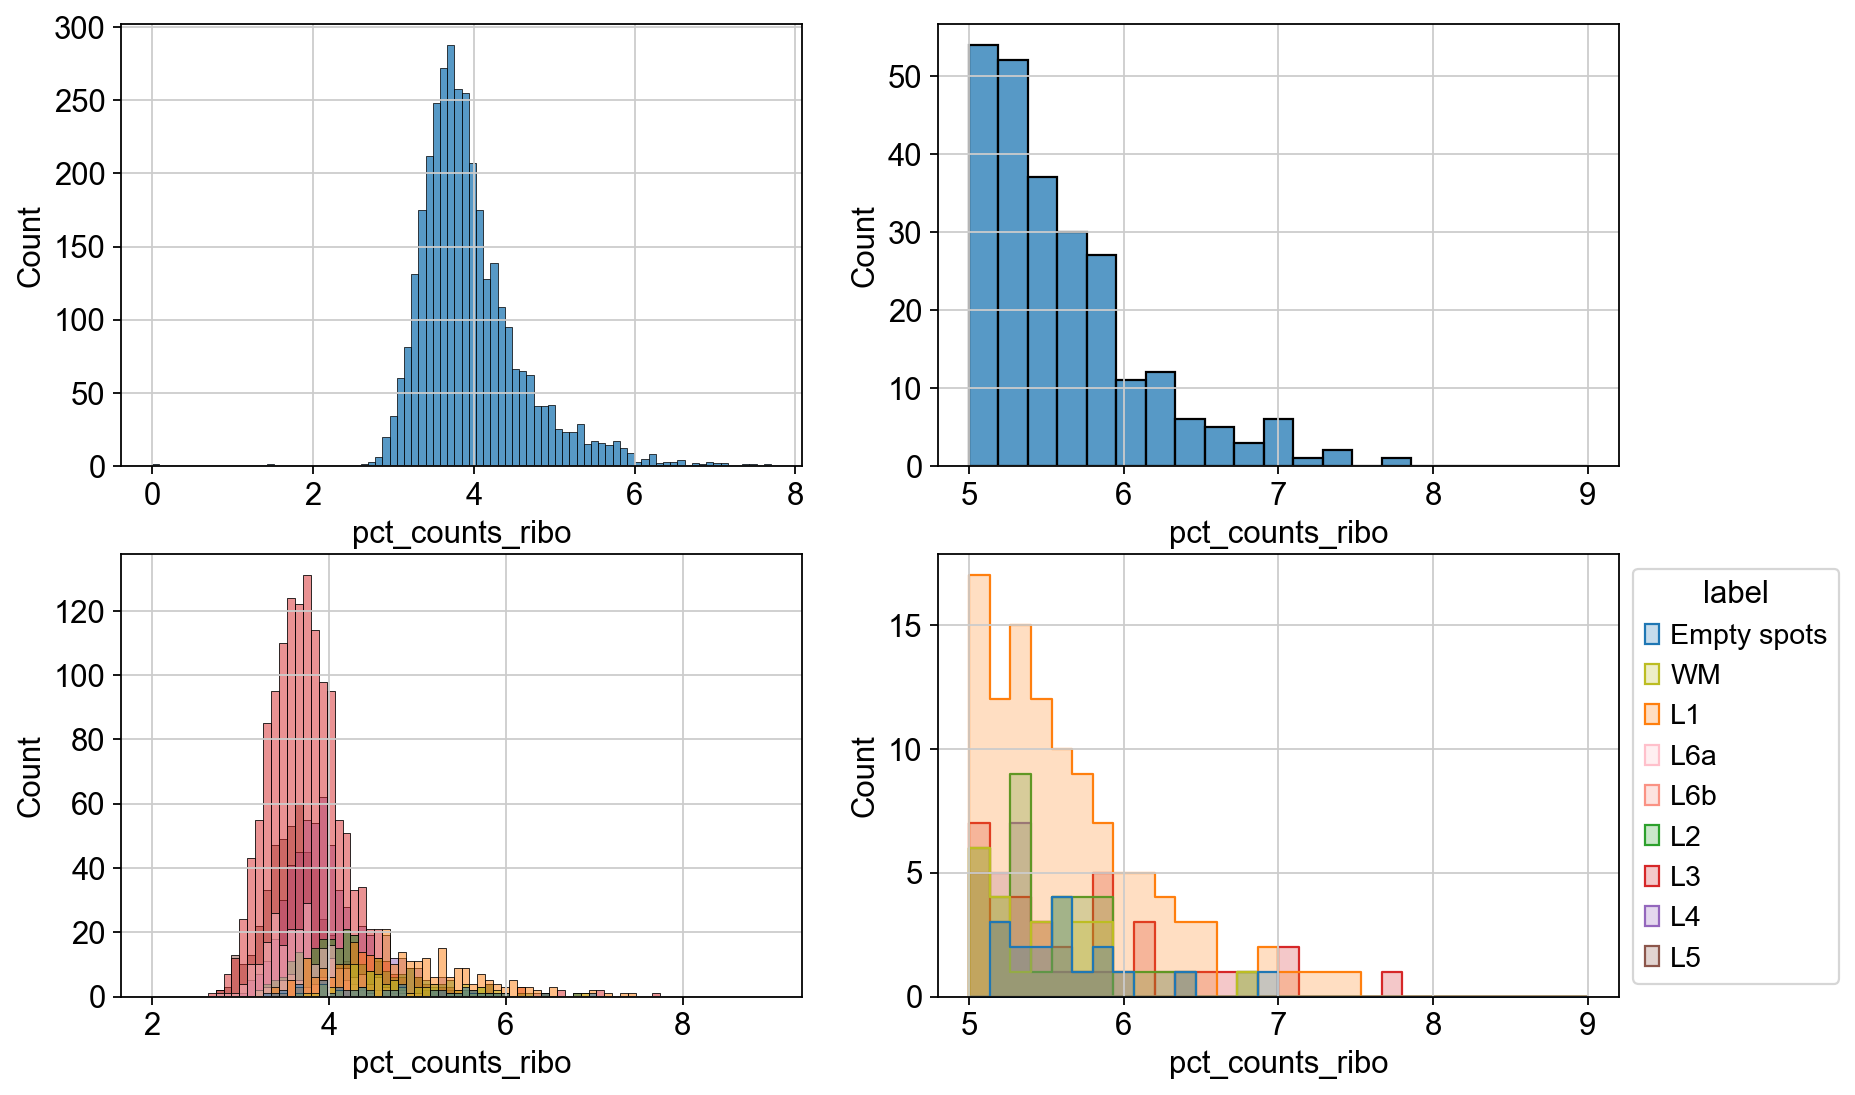

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='pct_counts_ribo', ax=axs[0][0])
sns.histplot(adata.obs, x='pct_counts_ribo', binrange=[2, 9], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False, palette=layer_palette)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='pct_counts_ribo', binrange=[5, 9], ax=axs[0][1])
sns.histplot(adata.obs, x='pct_counts_ribo', binrange=[5, 9], hue='label', bins=30, hue_order=hue_order, ax=axs[1][1], fill=True, element="step", palette=layer_palette)
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Поставим для всех не из `L1` порог `pct_counts_mt = 25`, а для `L1` порог `pct_counts_mt = 32`.

In [23]:
adata.obs['qc_ribo'] = ((adata.obs['pct_counts_ribo'] <= 7.5)).astype('string')
#adata.obs['qc_mt'].replace({True: 'TRUE', False: 'FALSE'}, inplace=True)
vc = adata.obs.groupby('qc_ribo')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_ribo'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=1

label
L3    1
Name: label, dtype: int64


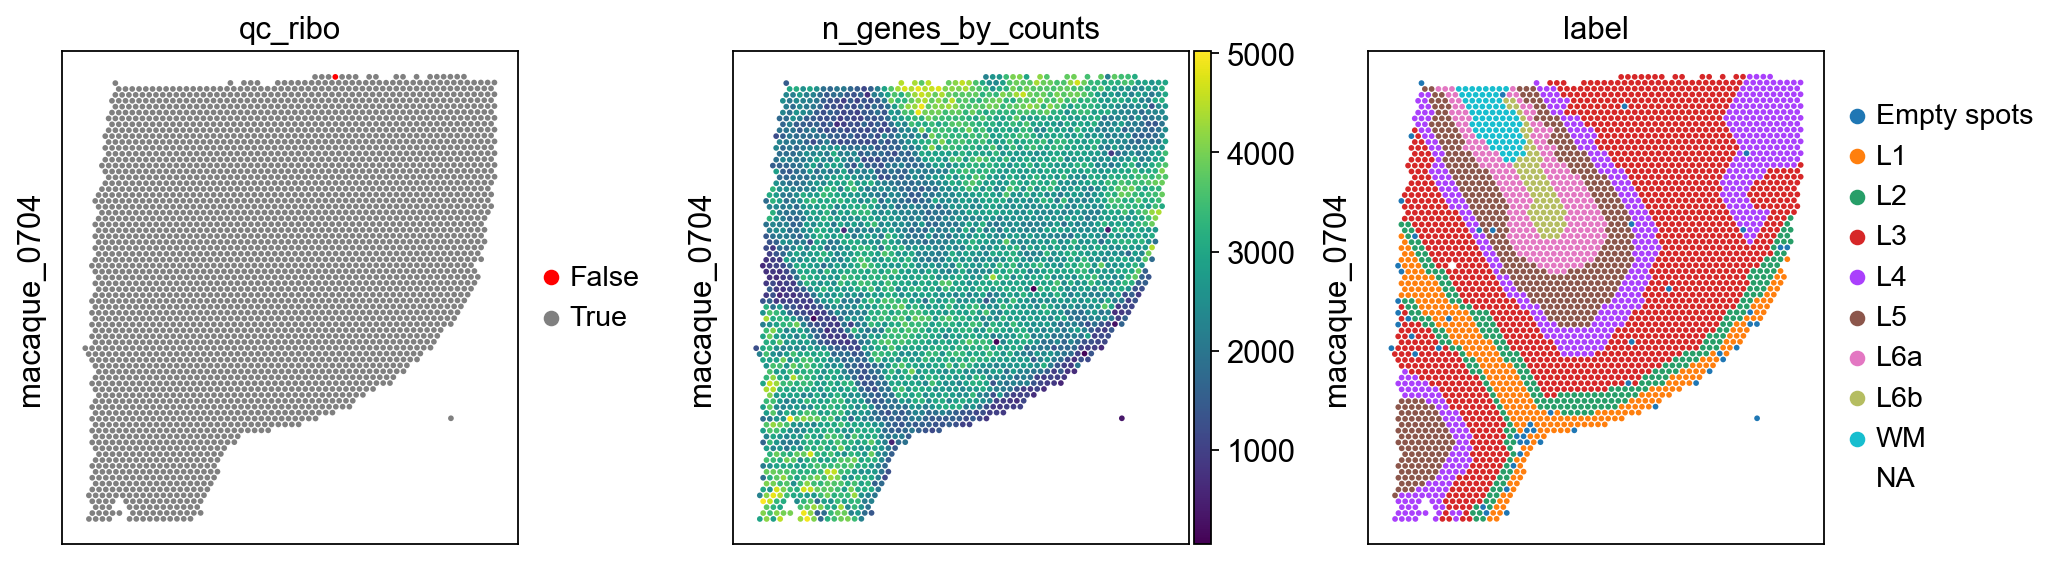

In [24]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_ribo', 'n_genes_by_counts', 'label'], img=False, axis_label=['', file], size=1.3)

## Combined

### QC spatial_scatter

In [25]:
d = {'True': True, 'False': False}
adata.obs['qc_lib_size'] = adata.obs['qc_lib_size'].astype(object).replace(d)
adata.obs['qc_n_genes'] = adata.obs['qc_n_genes'].astype(object).replace(d)
adata.obs['qc_ribo'] = adata.obs['qc_ribo'].astype(object).replace(d)

In [26]:
adata.obs['qc_good_spots'] = (adata.obs.qc_lib_size * adata.obs.qc_n_genes * adata.obs.qc_ribo).astype('string')
vc = adata.obs.groupby('qc_good_spots')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_good_spots'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=30

label
Empty spots    16
L1             12
L3              1
WM              1
Name: label, dtype: int64


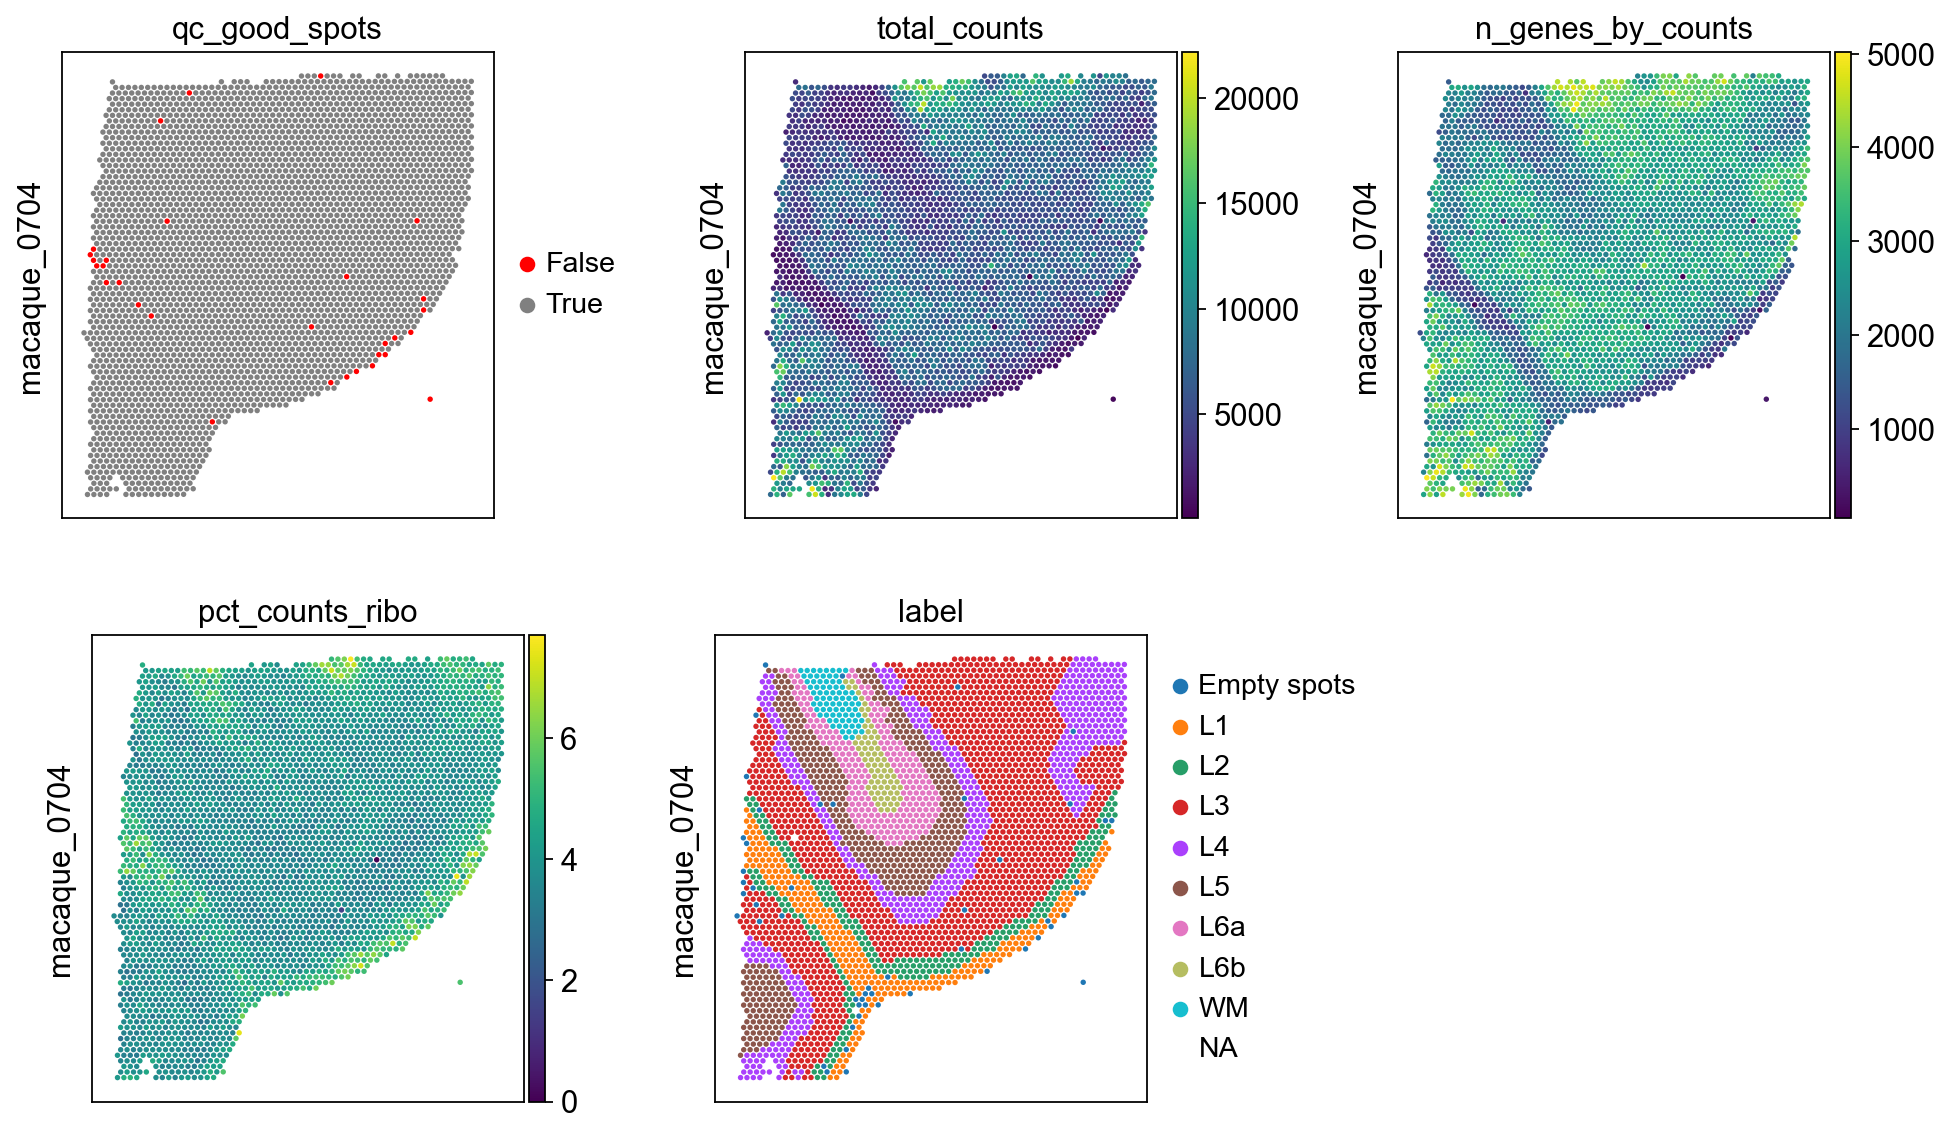

In [27]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_good_spots',  'total_counts', 'n_genes_by_counts', 'pct_counts_ribo', 'label'],
                          img=False, axis_label=['', file], size=1.3, ncols=3)

### QC scatter plots

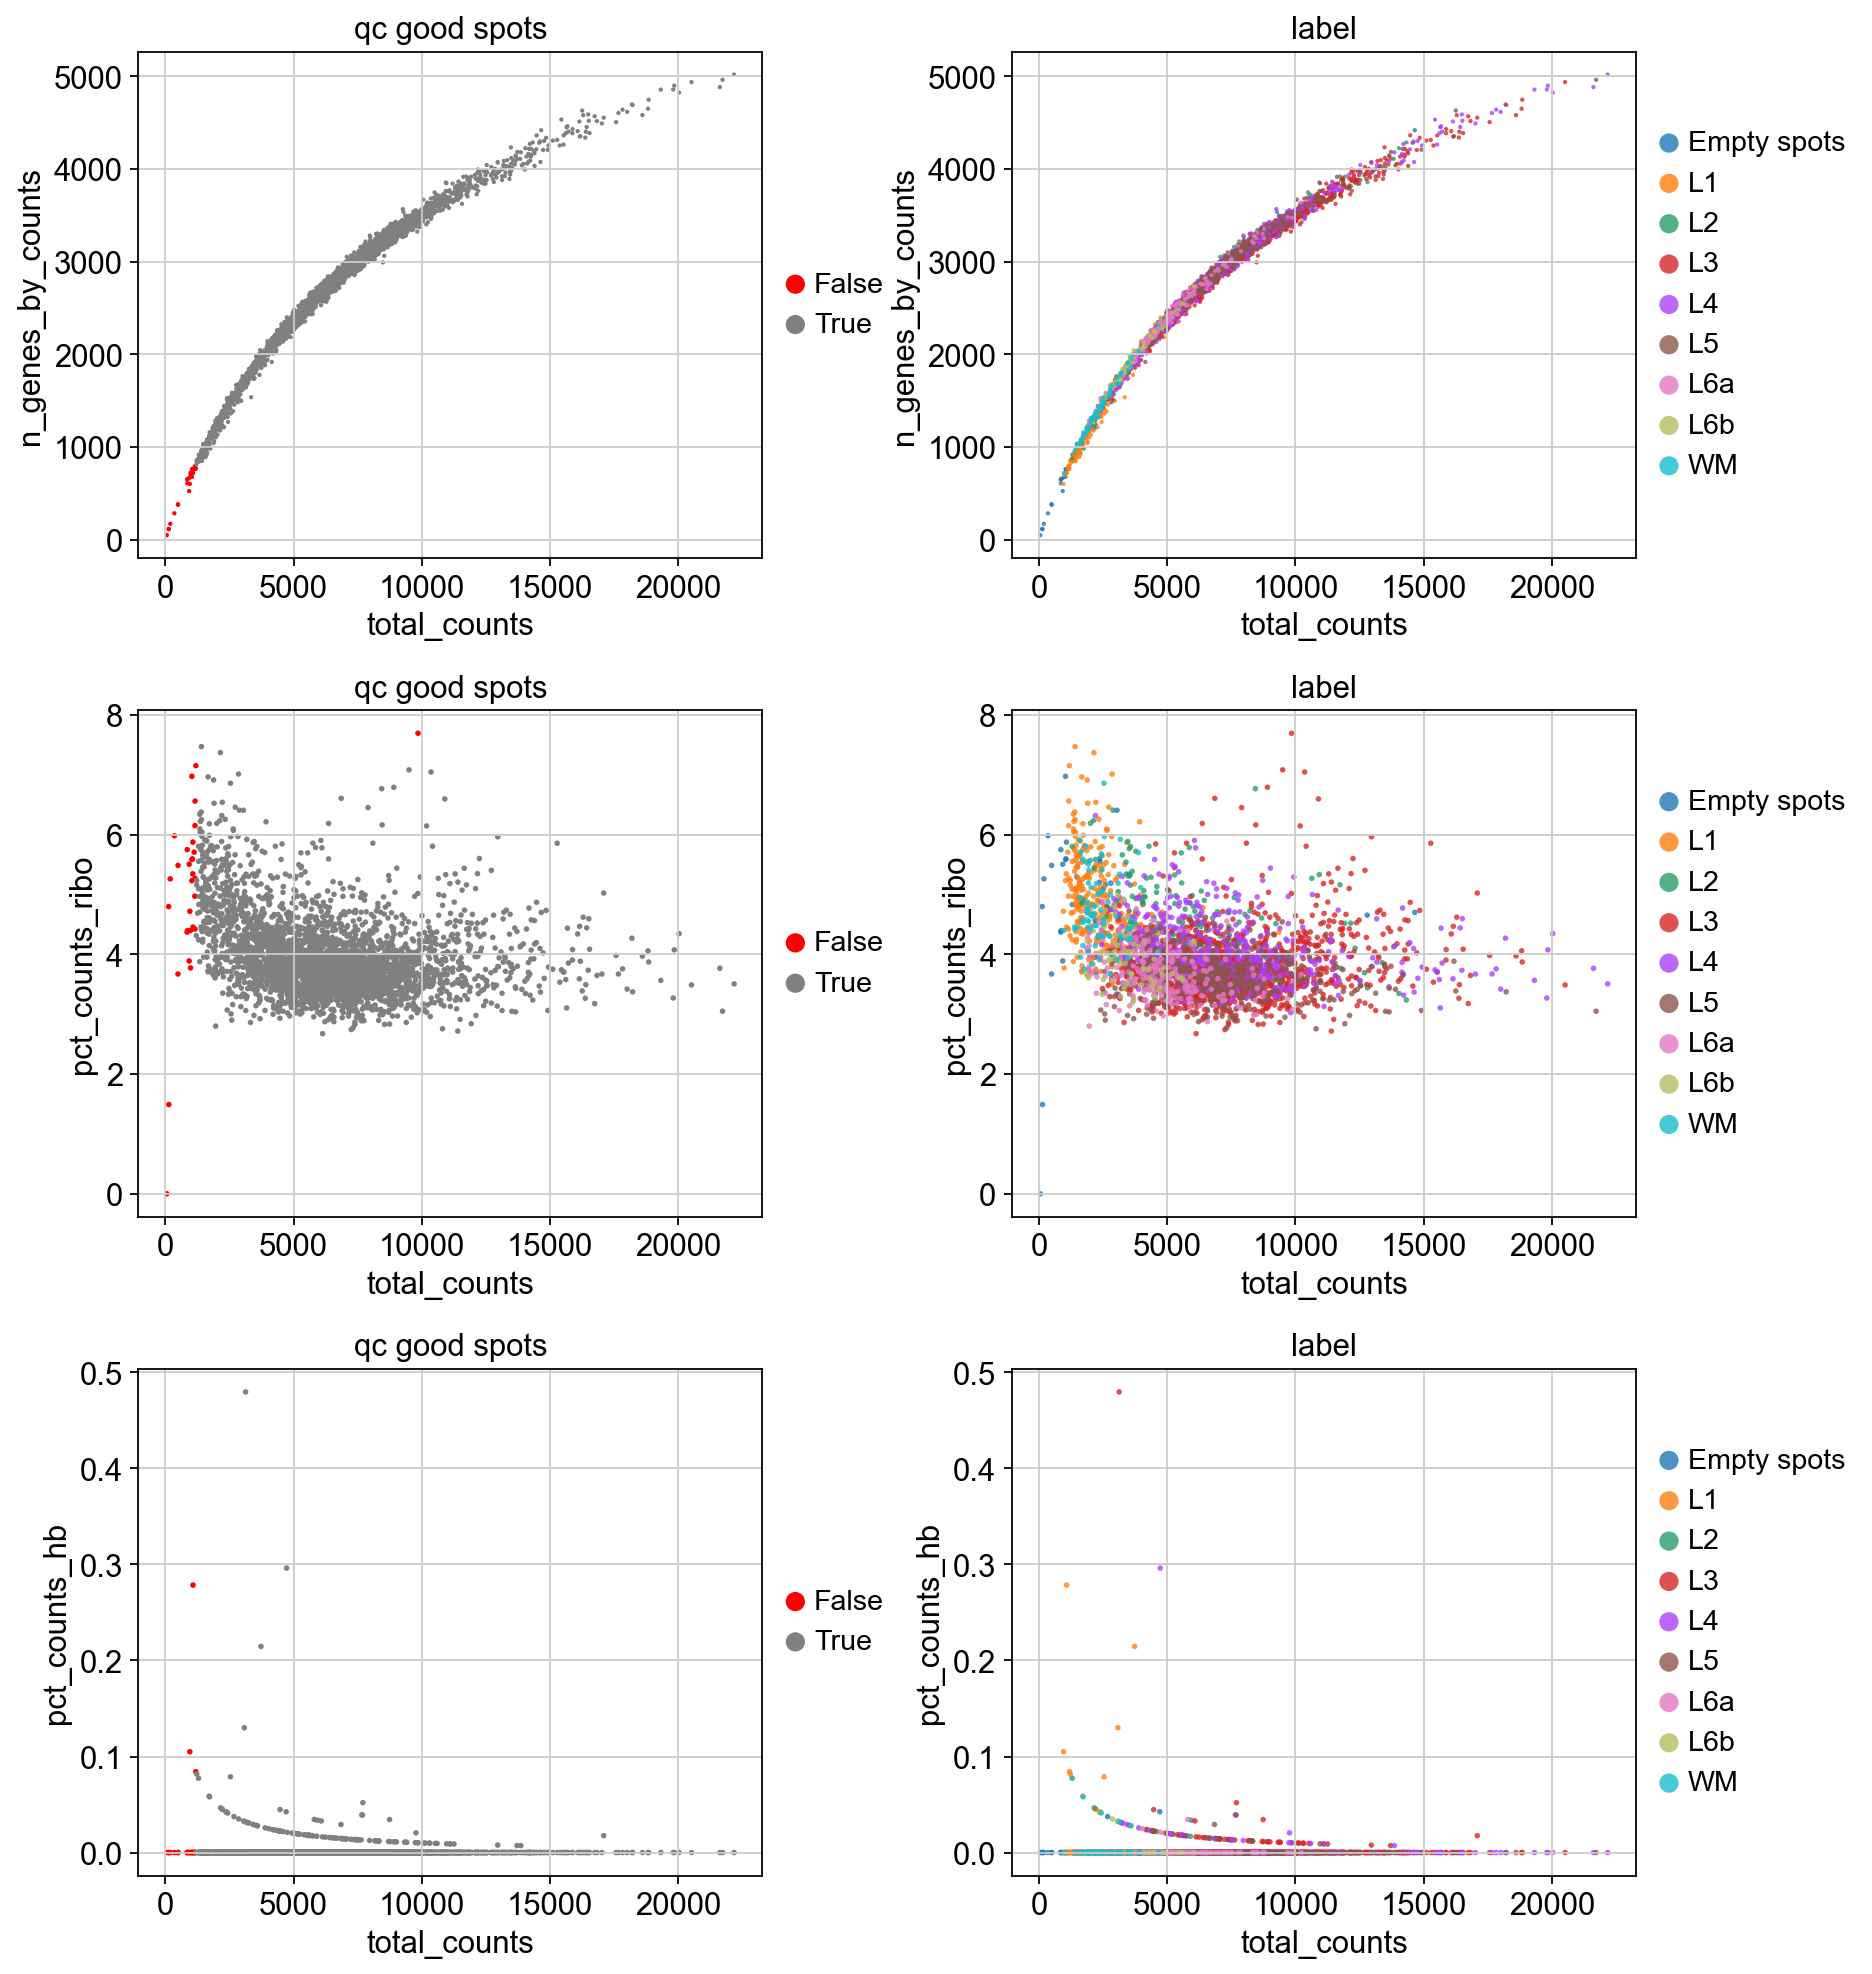

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15), gridspec_kw={'wspace': 0.4, 'hspace': 0.3})
alpha = 0.8


sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="qc_good_spots", ax=ax[0][0], show=False, size=15)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="label", ax=ax[0][1], show=False, alpha=alpha, size=15)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="qc_good_spots", ax=ax[1][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="label", ax=ax[1][1], show=False, alpha=alpha, size=25)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color="qc_good_spots", ax=ax[2][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color="label", ax=ax[2][1], show=False, alpha=alpha, size=25)

plt.show()

Если логарифмировать данные, то мы увидим, что во-первых это действительно гипербола, а во-вторых гиперболу образуют споты с одинаковым числом гемоглобиновых каунтов

In [75]:
no_zero_hb = adata.obs[adata.obs.pct_counts_hb > 0].index
log_pct_hb = np.log(adata.obs.loc[no_zero_hb, 'pct_counts_hb'])
log_total = np.log(adata.obs.loc[no_zero_hb, 'total_counts'])
hue_label = adata.obs.loc[no_zero_hb, 'label']

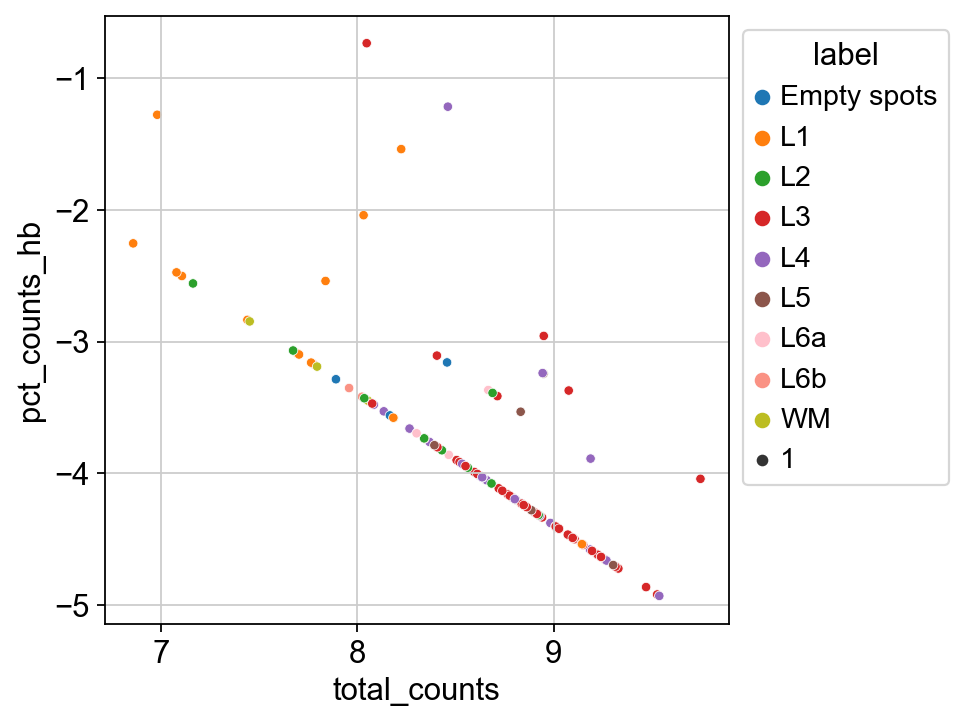

In [100]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=log_total, y=log_pct_hb, hue=hue_label, size=1, palette=layer_palette)
sns.move_legend(axs, "upper left", bbox_to_anchor=(1, 1))

### Cохраним отфильтрованые споты (без пустых)

In [84]:
good_spots = adata.obs[(adata.obs.qc_good_spots == 'True') & (adata.obs.label != 'Empty spots')].index

In [85]:
adata_filtered = adata[good_spots].copy()

### PCA

In [31]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:29)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


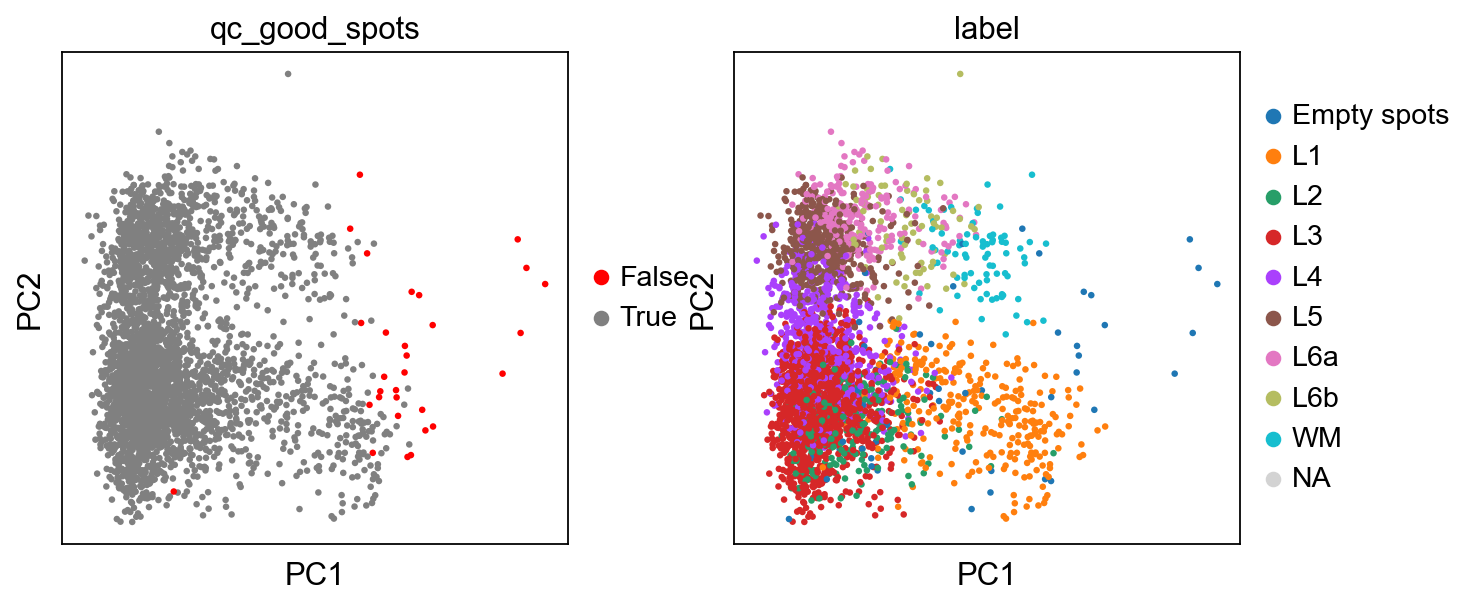

In [32]:
sc.pl.pca(adata, color=['qc_good_spots', 'label'])

Кажется вполне неплохо

## Сохраним в .h5ad

In [86]:
adata_filtered.obs.drop(['qc_lib_size','qc_n_genes', 'qc_good_spots', 'qc_ribo'], axis=1, inplace=True)

In [87]:
adata_filtered.obs.head()

in_tissue  array_row  array_col label     sample_id  \
AAACAAGTATCTCCCA-1          1         50        102    L1  macaque_0704   
AAACACCAATAACTGC-1          1         59         19    L5  macaque_0704   
AAACAGAGCGACTCCT-1          1         14         94    L3  macaque_0704   
AAACAGCTTTCAGAAG-1          1         43          9    L3  macaque_0704   
AAACAGGGTCTATATT-1          1         47         13    L3  macaque_0704   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACAAGTATCTCCCA-1               1240        2017.0              0.0   
AAACACCAATAACTGC-1               3158        8146.0              0.0   
AAACAGAGCGACTCCT-1               3322        9158.0              0.0   
AAACAGCTTTCAGAAG-1               4339       16372.0              0.0   
AAACAGGGTCTATATT-1               3750       11780.0              0.0   

                    pct_counts_mt  total_counts_hb  pct_counts_hb  \
AAACAAGTATCTCCCA-1            0.0              0.0            0.0   
AAACACCAATAACTGC-1            0.0              0.0            0.0   
AAACAGAGCGACTCCT-1            0.0              0.0            0.0   
AAACAGCTTTCAGAAG-1            0.0              0.0            0.0   
AAACAGGGTCTATATT-1            0.0              0.0            0.0   

                    total_counts_ribo  pct_counts_ribo  
AAACAAGTATCTCCCA-1               95.0         4.709965  
AAACACCAATAACTGC-1              326.0         4.001964  
AAACAGAGCGACTCCT-1              338.0         3.690762  
AAACAGCTTTCAGAAG-1              535.0         3.267774  
AAACAGGGTCTATATT-1              383.0         3.251273

In [88]:
os.makedirs('../results/filtered_samples', exist_ok=True)
os.makedirs('../results/filtered_samples/macaque', exist_ok=True)
adata_filtered.write_h5ad(f'../results/filtered_samples/macaque/{file}.h5ad')